This notebook presents examples of how to download and perform basic plotting and manipulation of MANGO airglow and FPI data.

MANGO Website: https://www.mangonetwork.org/mango/v1/

Illinois Airglow Website: https://airglow.ece.illinois.edu

Scan to go to GitHub repo: <img src="https://go.ece.illinois.edu/qr/CEDAR2024MANGOtutorial.png?rn=0613T123559" width="200">

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import subprocess
import h5py
from scipy.signal import medfilt2d
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import requests

### Some helper functions

In [2]:
def download_hdf5_files(url, save_dir):
    """
    Download all .hdf5 files from a given URL and save them to a specified directory.

    :param url: The URL of the web page to scrape for .hdf5 files.
    :param save_dir: The directory where the files will be saved.
    :return: List of paths to the downloaded files.
    """
    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Get the HTML content of the page
    response = requests.get(url)
    response.raise_for_status()  # Raise an error for bad status codes
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all links to .hdf5 files
    hdf5_links = []
    for link in soup.find_all('a', href=True):
        href = link['href']
        if href.endswith('.hdf5'):
            hdf5_links.append(urljoin(url, href))

    # Download each .hdf5 file
    downloaded_files = []
    for hdf5_url in hdf5_links:
        filename = os.path.basename(hdf5_url)
        file_path = os.path.join(save_dir, filename)
        
        # Download the file
        hdf5_response = requests.get(hdf5_url, stream=True)
        hdf5_response.raise_for_status()  # Raise an error for bad status codes

        with open(file_path, 'wb') as file:
            for chunk in hdf5_response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        downloaded_files.append(file_path)

    return downloaded_files

def download_mango_L1(site, emission, date, asi_directory=None):
    """
    Download MANGO L1 data for a specific site, emission, and date.

    Parameters:
    site (str): MANGO site abbreviation (e.g., "low").
    emission (str): Emission type ('green' or 'red').
    date (datetime): Date of interest.
    asi_directory (str): Directory to download data to. Defaults to the current directory.

    Returns:
    list: List of paths to the downloaded files.
    """
    downloaded_files = []

    if asi_directory is None:
        asi_directory = './'

    emission_path = 'greenline' if emission == 'green' else 'redline'
    target_directory = os.path.join(asi_directory, site, str(date.year), date.strftime('%j'))
    url = f'https://data.mangonetwork.org/data/transport/mango/archive/{site}/{emission_path}/level1/{date.year}/{date.strftime("%j")}/'
    
    downloaded_files = download_hdf5_files(url, target_directory)
    
    print(url)
    print(target_directory)

    return downloaded_files

def load_hdf5_to_xarray(file_path, kernel_size=7):
    """
    Load data from an HDF5 file into an xarray Dataset and apply a median filter to image data.

    Parameters:
    file_path (str): Path to the MANGO HDF5 file.
    kernel_size (int): Size of the 2D median filter to apply to each image. Defaults to 7.

    Returns:
    xarray.Dataset: Dataset containing the loaded data.
    """
    data_arrays = {}
    with h5py.File(file_path, 'r') as hdf:
        for key in hdf.keys():
            if isinstance(hdf[key], h5py.Dataset):
                data_arrays[key] = xr.DataArray(hdf[key][...], name=key)

    # Convert Unix times to datetime objects
    unix_times_start = data_arrays['UnixTime'][0].values
    start_times = pd.to_datetime(unix_times_start, unit='s', utc=True)

    unix_times_stop = data_arrays['UnixTime'][1].values
    stop_times = pd.to_datetime(unix_times_stop, unit='s', utc=True)

    # Calculate integration time and ensure it's a float
    integration_time_values = (stop_times - start_times).total_seconds()
    integration_time_values = integration_time_values.astype(float)

    # Ensure 'time' is numpy.datetime64
    start_times_np = np.array(start_times, dtype='datetime64[ns]')

    # Rename the dimensions of the ImageData
    image_data = data_arrays['ImageData'].rename({'dim_0': 'time', 'dim_1': 'north', 'dim_2': 'east'})
    image_data.attrs['description'] = 'Pixel values of image at each time step'

    # Process other variables
    azimuth = data_arrays['Azimuth'].rename({'dim_0': 'north', 'dim_1': 'east'})
    azimuth.attrs['units'] = 'Degrees'
    azimuth.attrs['description'] = 'Azimuth of each pixel'
    elevation = data_arrays['Elevation'].rename({'dim_0': 'north', 'dim_1': 'east'})
    elevation.attrs['units'] = 'Degrees'
    elevation.attrs['description'] = 'Elevation of each pixel'
    latitude = data_arrays['Latitude'].rename({'dim_0': 'north', 'dim_1': 'east'})
    latitude.attrs['units'] = 'Degrees N'
    latitude.attrs['description'] = 'Geodetic latitude of each pixel'
    longitude = data_arrays['Longitude'].rename({'dim_0': 'north', 'dim_1': 'east'})
    longitude.attrs['units'] = 'Degrees E'
    longitude.attrs['description'] = 'Geodetic longitude of each pixel'
    CCDTemperature = data_arrays['CCDTemperature'].rename({'dim_0': 'time'})
    CCDTemperature.attrs['units'] = 'Celsius'
    CCDTemperature.attrs['description'] = 'Temperature of CCD'

    north_array = xr.DataArray(data_arrays['PixelCoordinates'][0][0, :], dims=('north'))
    north_array.attrs['units'] = 'km'
    north_array.attrs['description'] = 'Distance in north direction from site at airglow layer'
    east_array = xr.DataArray(data_arrays['PixelCoordinates'][1][:, 0], dims=('east'))
    east_array.attrs['units'] = 'km'
    east_array.attrs['description'] = 'Distance in east direction from site at airglow layer'

    # Apply median filter to each image
    im_ds = []
    for id in image_data:
        temp = xr.DataArray(medfilt2d(id, kernel_size=kernel_size), dims=('north', 'east'))
        im_ds.append(temp)

    combined = xr.concat(im_ds, dim='time')
    combined.attrs['description'] = 'Pixel values of image at each time step after median filter'

    integration_time = xr.DataArray(integration_time_values, coords={'time': start_times_np}, dims=('time'))
    integration_time.attrs['units'] = 's'
    integration_time.attrs['description'] = 'Integration time of the image'

    # Create xarray Dataset
    ds = xr.Dataset({
        'integration_time': integration_time,
        'ImageData': combined,
        'Azimuth': azimuth,
        'Elevation': elevation,
        'Latitude': latitude,
        'Longitude': longitude,
        'CCDTemperature': CCDTemperature,
        'east': east_array,
        'north': north_array
    })

    return ds


### Setup information about the dataset to be worked on

In [3]:
site = 'blo'
emission = 'green'
date = datetime.datetime(2023,5,11)
asi_directory = '/home/airglow/scratch_data/CEDAR_test/MANGO_Data'

### Download data and load in the HDF5 file

In [5]:
downloaded_data = download_mango_L1(site,emission,date,asi_directory=asi_directory)

https://data.mangonetwork.org/data/transport/mango/archive/blo/greenline/level1/2023/131/
/home/airglow/scratch_data/CEDAR_test/MANGO_Data/blo/2023/131


In [6]:
# ds is our dataset
ds = {}
ds[site] = load_hdf5_to_xarray(downloaded_data[0])

### Examine the loaded dataset
The dataset is an xarray data structure containing information from the HDF5 file and has the following format:

Coordinates:
* time (datetime64) - time stamps of each image in the data set
* east (float) - east km distance from the center of the image. This is a uniform step.
* north (float) - north km distance from the center of the image. This is a uniform step.

Data Variable:
* integration_time (float) - integration time for each image in sec (dim: time)
* ImageData (int) - intensity values in the image (dims: time, north, east)
                  the image data has had a 7x7 median filter applied to remove stars
* Azimuth (float) - azimuth for each pixel, in deg (dims: north, east)
* Elevation (float) - elevation for each pixel, in deg (dims: north, east)
* Latitude (float) - latitude for each pixel, in deg N (dims: north, east)
* Longitude (float) - longtitude for each pixel, in deg E (dims: north, east)
* CCDTemperature (float) - CCD temperature, in C (dim: time)

In [27]:
ds['blo']

<xarray.Dataset>
Dimensions:            (time: 173, north: 500, east: 500)
Coordinates:
  * time               (time) datetime64[ns] 2023-05-11T04:30:00 ... 2023-05-...
  * east               (east) float64 -324.3 -323.0 -321.7 ... 321.7 323.0 324.3
  * north              (north) float64 -324.3 -323.0 -321.7 ... 323.0 324.3
Data variables:
    integration_time   (time) float64 110.0 110.0 110.0 ... 110.0 110.0 110.0
    ImageData          (time, north, east) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    Azimuth            (north, east) float64 -135.0 -135.1 -135.2 ... 44.88 45.0
    Elevation          (north, east) float64 9.749 9.776 9.803 ... 9.776 9.749
    Latitude           (north, east) float64 39.0 39.0 39.0 ... 44.74 44.74
    Longitude          (north, east) float64 -115.1 -115.1 ... -107.4 -107.4
    CCDTemperature     (time) float64 -4.95 -4.71 -5.35 ... -4.95 -5.27 -4.95
    FilteredImageData  (time, north, east) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

### Manipulate data
The xarray format allows easy manipulation and plotting of the data

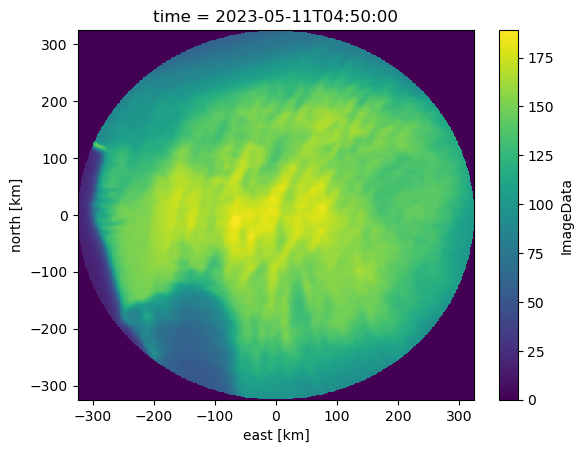

In [9]:
ds['blo'].ImageData.isel(time=10).plot()

/tmp/ipykernel_315658/1358771184.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0])


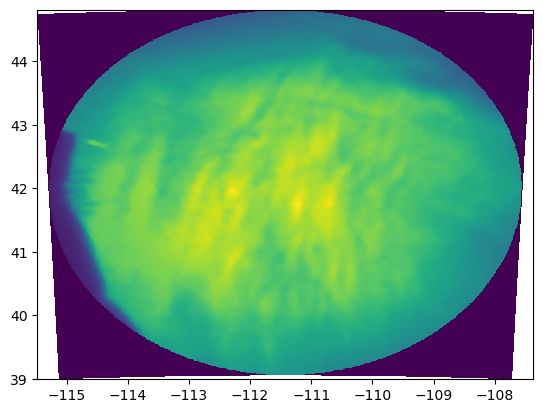

In [10]:
plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0])

### You can easily create masks to remove low-elevation obstructions

/tmp/ipykernel_315658/1806600765.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0].where(mask))


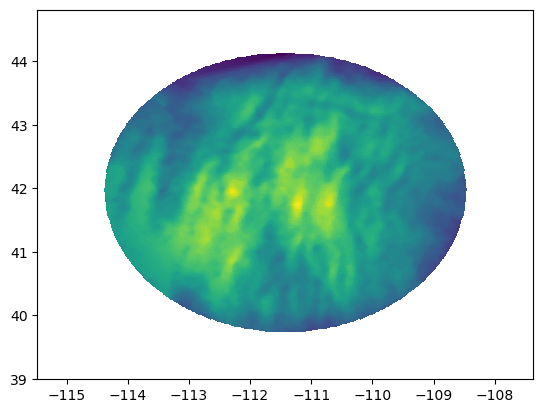

In [11]:
mask = ds['blo'].Elevation > 20.
plt.pcolormesh(ds['blo'].Longitude,ds['blo'].Latitude,ds['blo'].ImageData[0].where(mask))

### You can plot the average intensity over time of the high-elevation angle pixels

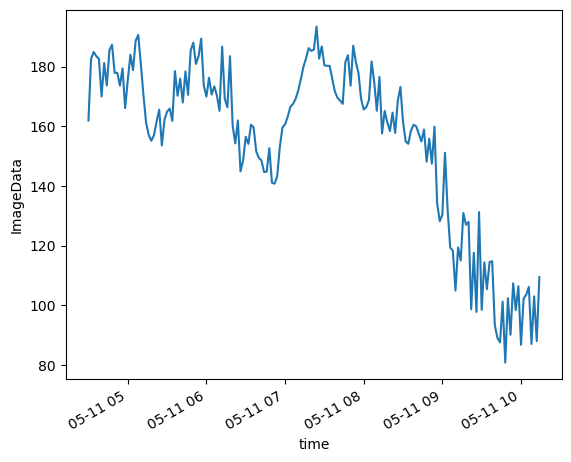

In [28]:
ze_mask = ds['blo'].Elevation > 85
ds['blo'].ImageData.where(ze_mask).mean(dim=['east','north']).plot()

### You can create sub-images

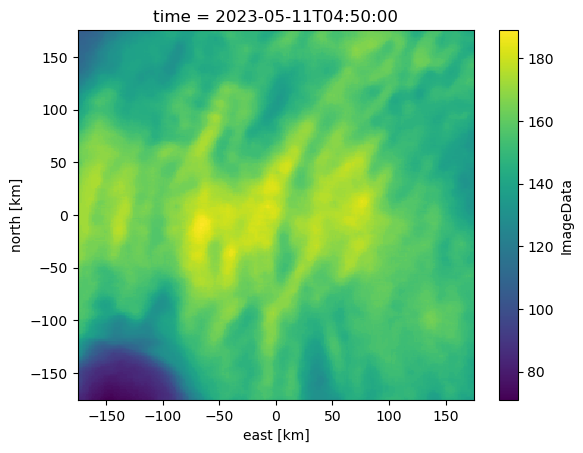

In [13]:
# Find the square inscribed in the circle. The side of the square that can be inscribed
# in a circle of radius r is sqrt(2)*r. Find the smallest dimension in the east and north
# arrays and use that as the radius. May need to tweak this for imagers that have obstructions
# above el_cutoff
min_r = np.min([np.abs(ds['blo'].east.where(mask)).max(),np.abs(ds['blo'].north.where(mask)).max()])
r = np.floor(np.sqrt(2)*min_r/2.)
subset = ds['blo'].sel(east=slice(-r,r), north=slice(-r,r))
subset.isel(time=10).ImageData.plot()

### You can temporally filter the data

In [14]:
import scipy.signal as signal
import multiprocessing as mp

# Calculate the sampling period (in seconds)
sampling_periods = pd.to_timedelta(ds['blo'].time.diff(dim='time').values.mean()).total_seconds()

# Desired filter parameters
ntaps = 13
Tlo = 2   # minutes
Thi = 20  # minutes

# Design the filter
fs = 1./sampling_periods
cutofflo = 1./(Thi*60.)
cutoffhi = 1./(Tlo*60.)
fir_coeff = signal.firwin(ntaps, [cutofflo], pass_zero=False, fs=fs)

# Function to apply the filter to a subset of the data
def apply_filter(sub_data):
    return signal.filtfilt(fir_coeff, 1.0, sub_data, axis=0)

# Split the data for parallel processing
def parallel_filter(ds, var_name, n_jobs=mp.cpu_count()//2):
    data = ds[var_name].values
    shape = data.shape
    
    # Reshape data to apply filter independently on each (north, east) pair
    reshaped_data = data.reshape(shape[0], -1)
    
    # Use multiprocessing to filter data in parallel
    with mp.Pool(processes=n_jobs) as pool:
        filtered_data = pool.map(apply_filter, [reshaped_data[:, i] for i in range(reshaped_data.shape[1])])
    
    # Combine the filtered data back into the original shape
    filtered_data = np.array(filtered_data).T.reshape(shape)
    
    # Create a new xarray Dataset with the filtered data
    ds['FilteredImageData'] = (('time', 'north', 'east'), filtered_data)
    
    return ds

# IF USING MULTIPROCESSING
# Apply the parallel filter
ds['blo'] = parallel_filter(ds['blo'], 'ImageData')

# IF NOT USING MULTIPROCESSING
# Apply the FIR filter using filtfilt to avoid time offset
#filtered_data = signal.filtfilt(fir_coeff, 1.0, ds['blo'].ImageData, axis=0)
#ds['blo']['FilteredImageData'] = (('time','north','east'), filtered_data)

### We can now display the filtered data, or a subset, in various coordinates

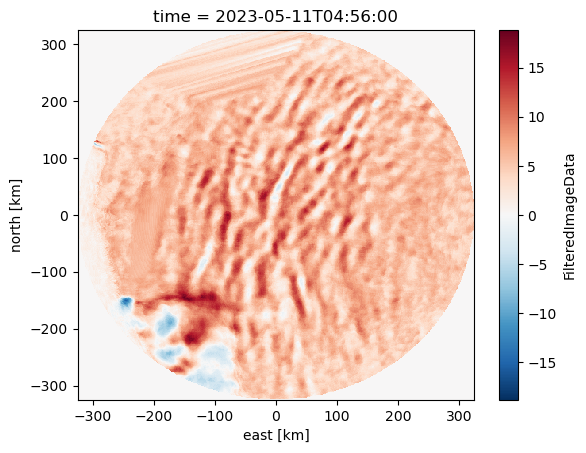

In [15]:
ds['blo'].FilteredImageData.isel(time=13).plot()

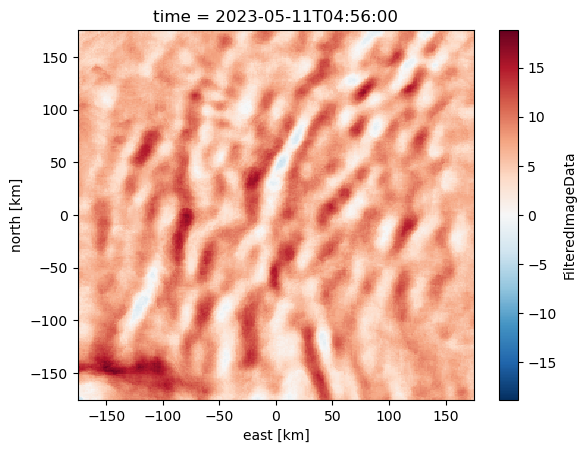

In [16]:
subset = ds['blo'].sel(east=slice(-r,r), north=slice(-r,r))
subset.isel(time=13).FilteredImageData.plot()

In [29]:
import ipywidgets as widgets
from ipywidgets import interact

background_subtract = subset.FilteredImageData - subset.FilteredImageData.mean(dim=['east','north'])

# Function to update the plot
def update_plot(time_index):
    background_subtract.isel(time=time_index).plot(vmin=-15, vmax=15, cmap='bwr')

# Create an interactive widget
interact(update_plot, time_index=widgets.IntSlider(min=0, max=len(subset.time)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='time_index', max=172), Output()), _dom_classes=('widget-…

<function __main__.update_plot(time_index)>

### Can load another site and plot both imagers on a map

In [19]:
sites = ['low','cvo', 'cfs']
downloaded_data = []

for s in sites:
    downloaded_data.append(download_mango_L1(s,emission,date,asi_directory=asi_directory))

for (s, f) in zip(sites,downloaded_data):
    ds[s] = load_hdf5_to_xarray(f[0])

https://data.mangonetwork.org/data/transport/mango/archive/low/greenline/level1/2023/131/
/home/airglow/scratch_data/CEDAR_test/MANGO_Data/low/2023/131
https://data.mangonetwork.org/data/transport/mango/archive/cvo/greenline/level1/2023/131/
/home/airglow/scratch_data/CEDAR_test/MANGO_Data/cvo/2023/131
https://data.mangonetwork.org/data/transport/mango/archive/cfs/greenline/level1/2023/131/
/home/airglow/scratch_data/CEDAR_test/MANGO_Data/cfs/2023/131


Text(0.5, 1.0, '2023-05-11 05:34:00')

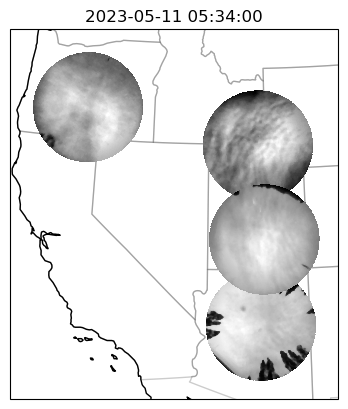

In [20]:
from cartopy import crs,feature

# We will plot images closest to a specific time
target_time = np.datetime64('2023-05-11T05:34:00.000000000')

extent=[-124,-102,30,48]
fig = plt.figure()
axes00 = fig.add_subplot(projection=crs.Orthographic(np.nanmean(extent[:2]),np.nanmean(extent[2:])))
axes00.add_feature(feature.COASTLINE)
axes00.add_feature(feature.STATES,alpha=0.2,zorder=1)

for k in ds.keys():
    nearest_time = ds[k].sel(time=target_time, method='nearest')
    time_difference = abs(pd.to_timedelta(nearest_time.time.values - target_time).total_seconds())

    if time_difference < 10:
        data = ds[k].sel(time=target_time, method='nearest')
        
        latitude = data.Latitude
        longitude = data.Longitude
        mask = data.Elevation > 20.

        pc = axes00.pcolormesh(longitude,latitude,data.ImageData.where(mask),transform=crs.PlateCarree(),cmap='gray')

axes00.set_title(pd.to_datetime(str(target_time)))

In [21]:
# Let's filter the data and plot it
for s in ds.keys():
    ds[s] = parallel_filter(ds[s], 'ImageData')

Text(0.5, 1.0, '2023-05-11 05:34:00')

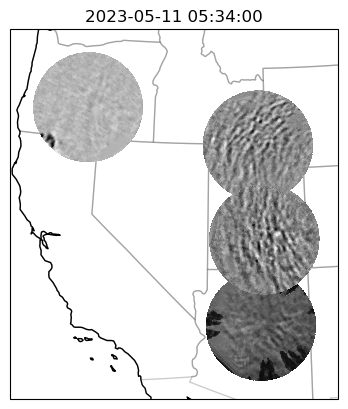

In [22]:
from cartopy import crs,feature

# We will plot images closest to a specific time
target_time = np.datetime64('2023-05-11T05:34:00.000000000')

# Define the map extent (region to be plotted)
extent=[-124,-102,30,48]
fig = plt.figure()
axes00 = fig.add_subplot(projection=crs.Orthographic(np.nanmean(extent[:2]),np.nanmean(extent[2:])))
axes00.add_feature(feature.COASTLINE)
axes00.add_feature(feature.STATES,alpha=0.2,zorder=1)

# Plot the background subtracted image that is closest to the target time (within 10 minutes)
for k in ds.keys():
    nearest_time = ds[k].sel(time=target_time, method='nearest')
    time_difference = abs(pd.to_timedelta(nearest_time.time.values - target_time).total_seconds())

    if time_difference < 10:
        data = ds[k].sel(time=target_time, method='nearest')
        
        latitude = data.Latitude
        longitude = data.Longitude
        mask = data.Elevation > 20.

        background_subtract = data.FilteredImageData - data.FilteredImageData.mean(dim=['east','north'])

        pc = axes00.pcolormesh(longitude,latitude,background_subtract.where(mask),transform=crs.PlateCarree(),cmap='gray')

axes00.set_title(pd.to_datetime(str(target_time)))

### Can load in FPI data and plot it

Used madrigalWeb to download relevant FPI data from LOW. the globalDownload.py function can be obtained by:

`wget http://cedar.openmadrigal.org/static/distributionFiles/madrigalWeb-3.2.3.tar.gz`

`globalDownload.py --verbose --url=http://cedar.openmadrigal.org --outputDir=/tmp --user_fullname="Jonathan+Makela" --user_email=jmakela@illinois.edu --user_affiliation="University+of+Illinois" --format="hdf5" --startDate="05/10/2023" --endDate="05/12/2023" --inst=5555`


### Define some helper functions needed to work with FPI data

In [23]:
def mangofpi_to_xarray(data_array):
    """
    Convert a structured array of MangoFPI data read from Madrigal HDF5 into an xarray Dataset.

    Parameters:
    data_array (np.recarray): Input structured array containing MangoFPI data with time and measurement fields.

    Returns:
    xarray.Dataset: The converted xarray Dataset with appropriately named variables and attributes.
    """
    # Extract time components and create time dimension
    time_dimension = create_time_dimension(data_array['year'], data_array['month'], data_array['day'],
                                           data_array['hour'], data_array['min'], data_array['sec'])

    # Create xarray Dataset
    data_vars = {
        name: (('time',), data_array[name]) 
        for name in data_array.dtype.names if name not in ['year', 'month', 'day', 'hour', 'min', 'sec']
    }
    xr_dataset = xr.Dataset(data_vars, coords={'time': time_dimension})

    # Set attributes for each variable
    xr_dataset.elm.attrs['units'] = 'Degrees'
    xr_dataset.elm.attrs['description'] = 'Elevation angle (0=horizontal;90=vertical)'
    xr_dataset.azm.attrs['units'] = 'Degrees'
    xr_dataset.azm.attrs['description'] = 'Mean azimuth angle (0=geographic north;90=east)'
    xr_dataset.vnu.attrs['units'] = 'm/s'
    xr_dataset.vnu.attrs['description'] = 'Line of sight neutral velocity (positive = away)'
    xr_dataset.dvnu.attrs['units'] = 'm/s'
    xr_dataset.dvnu.attrs['description'] = 'Error in line of sight neutral velocity'
    xr_dataset.tn.attrs['units'] = 'K'
    xr_dataset.tn.attrs['description'] = 'Neutral atmosphere temperature (Tn)'
    xr_dataset.dtn.attrs['units'] = 'K'
    xr_dataset.dtn.attrs['description'] = 'Error in neutral atmosphere temperature (Tn)'
    xr_dataset.gdalt.attrs['units'] = 'km'
    xr_dataset.gdalt.attrs['description'] = 'Geodetic altitude (height)'
    xr_dataset.rlel.attrs['units'] = 'N/A'
    xr_dataset.rlel.attrs['description'] = 'Log10 relative (uncalibrated) emission'
    xr_dataset.cloudind.attrs['units'] = 'C'
    xr_dataset.cloudind.attrs['description'] = 'Ambient temperature - sky temperature. < -25 implies clear'
    xr_dataset.temp_err.attrs['units'] = 'N/A'
    xr_dataset.temp_err.attrs['description'] = 'Temperature flag: 0=ok; 1=caution; 2=likely bad'
    xr_dataset.wind_err.attrs['units'] = 'N/A'
    xr_dataset.wind_err.attrs['description'] = 'Wind flag: 0=ok; 1=caution; 2=likely bad'
    xr_dataset.doppl_ref.attrs['units'] = 'N/A'
    xr_dataset.doppl_ref.attrs['description'] = 'Doppler calibration: 1=laser; 0=no vertical winds'
    xr_dataset.fit_sigma.attrs['units'] = 'm/s'
    xr_dataset.fit_sigma.attrs['description'] = 'Wind uncertainty - least squares fit to sky fringes'
    xr_dataset.cal_sigma.attrs['units'] = 'm/s'
    xr_dataset.cal_sigma.attrs['description'] = 'Wind uncertainty - fluctuation in calibration source'

    # Drop unnecessary variables from the Dataset
    xr_dataset = xr_dataset.drop_vars(['recno', 'kindat', 'kinst', 'dgdalt', 'drlel'])

    return xr_dataset

def create_time_dimension(year, month, day, hour, minute, second):
    """
    Convert separate time-related components into a single datetime64 array.

    Parameters:
    year (np.ndarray): Array of year values.
    month (np.ndarray): Array of month values.
    day (np.ndarray): Array of day values.
    hour (np.ndarray): Array of hour values.
    minute (np.ndarray): Array of minute values.
    second (np.ndarray): Array of second values.

    Returns:
    np.ndarray: A numpy array of datetime64[ns] values.
    """
    # Ensure all inputs are appropriately formatted and zero-padded
    datetime_strings = [
        f"{int(y):04d}-{int(mo):02d}-{int(d):02d}T{int(h):02d}:{int(mi):02d}:{int(s):02d}"
        for y, mo, d, h, mi, s in zip(year, month, day, hour, minute, second)
    ]

    # Convert the list of date-time strings to a numpy array with dtype 'datetime64[ns]'
    return np.array(datetime_strings, dtype='datetime64[ns]')

def DopplerReference(xr_array, vertical_mask, reference='laser'):
    """
    Calculate and add Doppler reference values to an xarray dataset based on a specified reference method.

    Parameters:
    xr_array (xarray.Dataset): The input dataset containing Doppler velocity ('vnu') and error ('dvnu') data.
    vertical_mask (xarray.DataArray): A mask array to identify vertical Doppler values.
    reference (str): The reference method to use ('laser' or 'zenith'). Defaults to 'laser'.

    Returns:
    xarray.Dataset: The input dataset with added Doppler reference values ('ref_Dop') and their uncertainties ('e_ref_Dop').
    """

    # Mask vertical values and drop NaNs
    clean_vertical_values = xr_array.vnu.where(vertical_mask).dropna(dim='time')
    clean_vertical_errors = xr_array.dvnu.where(vertical_mask).dropna(dim='time')

    # Process based on the requested Doppler reference
    if reference == 'zenith':
        # Interpolate the zenith Doppler values
        ref_Dop = clean_vertical_values.interp(time=xr_array.time)
        e_ref_Dop = clean_vertical_errors.interp(time=xr_array.time)
    elif reference == 'laser':
        # Use the mode statistic by finding value which minimizes Lp-norm of residual, for small p
        res = 0.1  # m/s, desired resolution
        p = 0.1  # norm

        # Find minimum weighted norm Doppler reference
        mxz = np.percentile(clean_vertical_values, 90)
        mnz = np.percentile(clean_vertical_values, 10)

        if mxz < mnz:
            # There aren't many samples. Just use actual min/max
            mxz = max(clean_vertical_values)
            mnz = min(clean_vertical_values)
        N = int((mxz - mnz) / res)

        if N > 1e6:
            # This is probably low-quality data, return the median value instead
            ref_Dop = xr.DataArray(np.median(clean_vertical_values) * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
            e_ref_Dop = xr.DataArray(np.median(clean_vertical_errors) * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
        else:
            dtest = np.linspace(mnz, mxz, N)
            cost = np.zeros(N)
            for j in range(N):
                d = dtest[j]

                # Doppler reference
                zcorr = clean_vertical_values - d

                # Evaluate metric
                cost[j] = sum(abs(zcorr / clean_vertical_errors) ** p)
            jstar = np.argmin(cost)
            offset = dtest[jstar]
            ref_Dop = xr.DataArray(offset * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})
            e_ref_Dop = xr.DataArray(offset * np.ones_like(xr_array.vnu), dims="time", coords={"time": xr_array.time})

    xr_array['ref_Dop'] = ref_Dop
    xr_array['e_ref_Dop'] = e_ref_Dop

    return xr_array

def los_2_horizontal(xr_array, los_mask, vertical_mask, direction):
    """
    Convert line-of-sight Doppler velocities to horizontal velocities in specified directions.

    Parameters:
    xr_array (xarray.Dataset): The input dataset containing Doppler velocity ('vnu'), error ('dvnu'), Doppler reference ('ref_Dop'), and elevation angle ('elm') data.
    los_mask (xarray.DataArray): A mask array to identify line-of-sight Doppler values.
    vertical_mask (xarray.DataArray): A mask array to identify vertical Doppler values.
    direction (str): The direction for horizontal conversion ('east', 'west', 'north', 'south', or 'zenith').

    Returns:
    xarray.Dataset: The input dataset with added horizontal velocity components ('u', 'v', 'w') and their uncertainties ('ue', 've', 'we').
    """

    # Identify time samples in the line of sight (los) direction
    time_samples_los = xr_array.time.where(los_mask, drop=True)

    # Identify the los values (removing the Doppler reference), uncertainties, and elevation angles
    clean_los_values = xr_array.vnu.where(los_mask).dropna(dim='time') - xr_array.ref_Dop.where(los_mask).dropna(dim='time')
    clean_los_errors = xr_array.dvnu.where(los_mask).dropna(dim='time')
    clean_elm = xr_array.elm.where(los_mask).dropna(dim='time')

    # Identify vertical values (removing the Doppler reference) and uncertainties
    clean_vertical_values = xr_array.vnu.where(vertical_mask).dropna(dim='time') - xr_array.ref_Dop.where(vertical_mask).dropna(dim='time')
    clean_vertical_errors = xr_array.dvnu.where(vertical_mask).dropna(dim='time')

    # Interpolate vertical values onto the time samples in the los direction
    interpolated_vertical = clean_vertical_values.interp(time=time_samples_los)
    interpolated_vertical_errors = clean_vertical_errors.interp(time=time_samples_los)

    # Run the math
    horizontal = (clean_los_values - interpolated_vertical * np.cos(np.deg2rad(clean_elm))) / np.sin(np.deg2rad(clean_elm))
    horizontal_e = np.sqrt(clean_los_errors ** 2 + interpolated_vertical_errors ** 2 * np.cos(np.deg2rad(clean_elm)) ** 2) / np.sin(np.deg2rad(clean_elm))

    # Align the coordinates before assignment
    horizontal = horizontal.reindex(time=xr_array.time)
    horizontal_e = horizontal_e.reindex(time=xr_array.time)

    if direction in ['east', 'west']:
        # Initialize the 'u' variable in the xr_array if it does not exist
        if 'u' not in xr_array:
            xr_array['u'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 'ue' not in xr_array:
            xr_array['ue'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'u' variable at the correct time indices
        if direction == 'east':
            xr_array['u'] = xr_array['u'].where(~los_mask, other=horizontal)
            xr_array['ue'] = xr_array['ue'].where(~los_mask, other=horizontal_e)
        else:
            xr_array['u'] = xr_array['u'].where(~los_mask, other=-horizontal)
            xr_array['ue'] = xr_array['ue'].where(~los_mask, other=horizontal_e)

    elif direction in ['north', 'south']:
        # Initialize the 'v' variable in the xr_array if it does not exist
        if 'v' not in xr_array:
            xr_array['v'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 've' not in xr_array:
            xr_array['ve'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'v' variable at the correct time indices
        if direction == 'north':
            xr_array['v'] = xr_array['v'].where(~los_mask, other=horizontal)
            xr_array['ve'] = xr_array['ve'].where(~los_mask, other=horizontal_e)
        else:
            xr_array['v'] = xr_array['v'].where(~los_mask, other=-horizontal)
            xr_array['ve'] = xr_array['ve'].where(~los_mask, other=horizontal_e)

    elif direction == 'zenith':
        this_w = interpolated_vertical
        this_e = interpolated_vertical_errors

        # Align coordinates before assignment
        this_w = this_w.reindex(time=xr_array.time)
        this_e = this_e.reindex(time=xr_array.time)

        # Initialize the 'w' variable in the xr_array if it does not exist
        if 'w' not in xr_array:
            xr_array['w'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})
        if 'we' not in xr_array:
            xr_array['we'] = xr.DataArray(np.full_like(xr_array.vnu, np.nan), dims="time", coords={"time": xr_array.time})

        # Assign the calculated values to the 'w' variable at the correct time indices
        xr_array['w'] = xr_array['w'].where(~los_mask, other=this_w)
        xr_array['we'] = xr_array['we'].where(~los_mask, other=this_e)

    return xr_array

### Load the HDF5 file downloaded from Madrigal

In [24]:
f = '/home/airglow/scratch_data/MANGO_Data/fpi/minime11_low_20230510_xg.cedar.034.hdf5'

# Open the HDF5 file
with h5py.File(f, 'r') as hdf5_file:
    # Access the dataset from the HDF5 file
    table_layout = hdf5_file['Data/Table Layout']
    
    # Read the data
    table_array = np.array(table_layout)
    
    # Convert to xarray Dataset
    xr_dataset = mangofpi_to_xarray(table_array)

### Define the look directions and convert from line-of-sight to horizontal winds

In [25]:
# Define el/az coords for each direction and create masks
east = (xr_dataset.elm == 45.) & (xr_dataset.azm == 90)
west = (xr_dataset.elm == 45.) & (xr_dataset.azm == -90)
north = (xr_dataset.elm == 45.) & (xr_dataset.azm == 0)
south = (xr_dataset.elm == 45.) & (xr_dataset.azm == 180)
vertical = (xr_dataset.elm == 90.)

# Set the Doppler reference
xr_dataset = DopplerReference(xr_dataset,vertical,reference='zenith')

# Convert to horizontal winds (u, v, w)
xr_dataset = los_2_horizontal(xr_dataset,east,vertical,'east')
xr_dataset = los_2_horizontal(xr_dataset,west,vertical,'west')
xr_dataset = los_2_horizontal(xr_dataset,north,vertical,'north')
xr_dataset = los_2_horizontal(xr_dataset,south,vertical,'south')
xr_dataset = los_2_horizontal(xr_dataset,vertical,vertical,'zenith')

### Create a plot of the horizontal winds

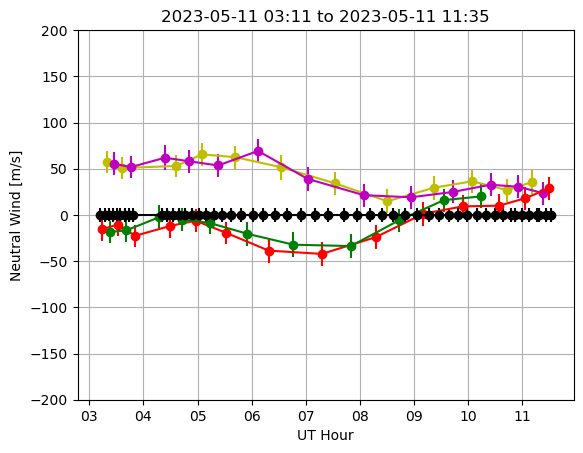

In [26]:
from matplotlib.dates import DateFormatter

plt.errorbar(xr_dataset.time.where(east,drop=True).values,xr_dataset.u.where(east,drop=True),yerr=xr_dataset.ue.where(east,drop=True),fmt='yo-')
plt.errorbar(xr_dataset.time.where(west,drop=True).values,xr_dataset.u.where(west,drop=True),yerr=xr_dataset.ue.where(west,drop=True),fmt='mo-')
plt.errorbar(xr_dataset.time.where(north,drop=True).values,xr_dataset.v.where(north,drop=True),yerr=xr_dataset.ve.where(north,drop=True),fmt='ro-')
plt.errorbar(xr_dataset.time.where(south,drop=True).values,xr_dataset.v.where(south,drop=True),yerr=xr_dataset.ve.where(south,drop=True),fmt='go-')
plt.errorbar(xr_dataset.time.where(vertical,drop=True).values,xr_dataset.w.where(vertical,drop=True),yerr=xr_dataset.we.where(vertical,drop=True),fmt='ko-')
plt.ylim([-200,200])

# Format the x-axis to display only the hour
date_formatter = DateFormatter('%H')
plt.gca().xaxis.set_major_formatter(date_formatter)
time_values = xr_dataset.time.values

## Generate a human-readable date range for the title
start_time = pd.to_datetime(time_values[0]).strftime('%Y-%m-%d %H:%M')
end_time = pd.to_datetime(time_values[-1]).strftime('%Y-%m-%d %H:%M')
plt.title(f'{start_time} to {end_time}')
plt.xlabel('UT Hour')
plt.ylabel('Neutral Wind [m/s]')
plt.grid()